<div style="background-color:rgba(0, 255, 255, 0.6);border-radius:5px;display:fill;">
    <h1><center style ="margin-left : 20px;">Plan</center></h1>
</div>

**After pre-processing and data analysis, I will create and stack several models to create an optimal model.**

(smoothing)**reference**  : https://www.kaggle.com/dustinthewind/making-sense-of-mean-encoding<br><br>
(stacking)**reference**  : https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda#notebook-container

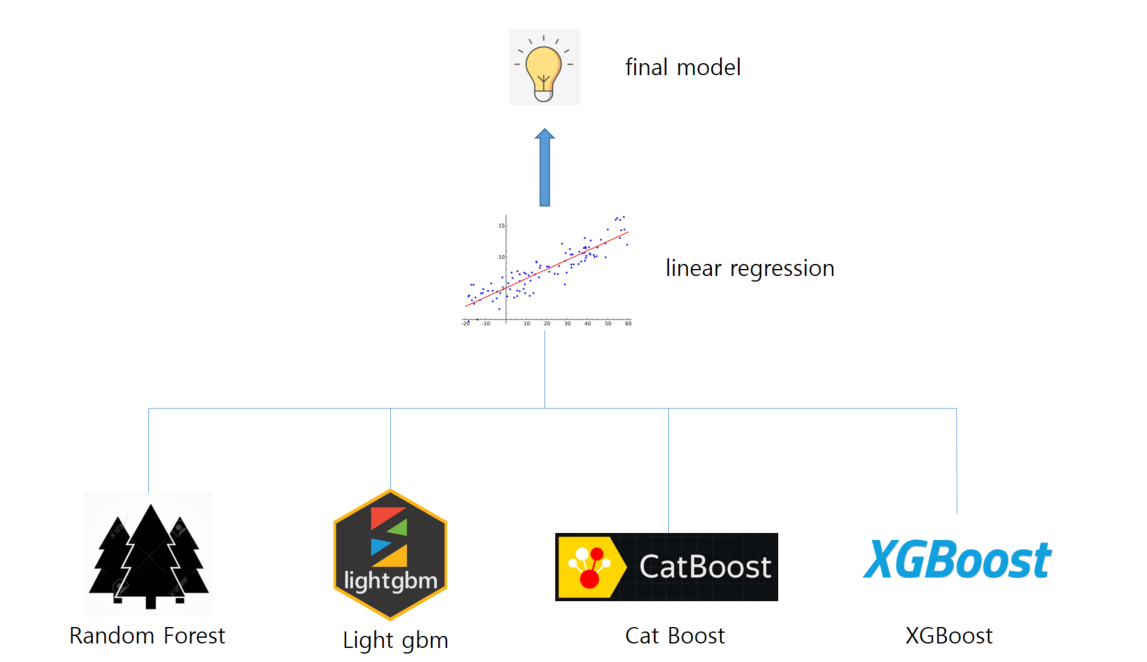

In [ ]:
#IMPORT THE LIBRARIES....
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import shap

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<div style="background-color:rgba(0, 255, 255, 0.6);border-radius:5px;display:fill;">
    <h1><center style ="margin-left : 20px;">import</center></h1>
</div>

In [ ]:
# data Load
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

<h3>Check for null values

In [ ]:
train.isnull().sum()[train.isnull().sum() != 0]

<h4>Remove features with more than half null values, exclude meaningless columns such as ID

In [ ]:
# train data 'id' remove
train_df = train.drop(['Id', 'MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'Alley'], axis=1)
test_df = test.drop(['Id', 'MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'Alley'], axis=1)

<div style="background-color:rgba(0, 0, 255, 0.6);border-radius:5px;display:fill;">
    <h1><center style ="margin-left : 20px;">Smoothing</center></h1>
</div>

In [ ]:
def encode_target_smooth(data, target, categ_variables, smooth):
    """    
    Apply target encoding with smoothing.
    
    Parameters
    ----------
    data: pd.DataFrame
    target: str, dependent variable
    categ_variables: list of str, variables to encode
    smooth: int, number of observations to weigh global average with
    
    Returns
    --------
    encoded_dataset: pd.DataFrame
    code_map: dict, mapping to be used on validation/test datasets 
    defaul_map: dict, mapping to replace previously unseen values with
    """
    train_target = data.copy()
    code_map = dict()    # stores mapping between original and encoded values
    default_map = dict() # stores global average of each variable
    
    for v in categ_variables:
        prior = data[target].mean()
        n = data.groupby(v).size()
        mu = data.groupby(v)[target].mean()
        mu_smoothed = (n * mu + smooth * prior) / (n + smooth)
        
        train_target.loc[:, v] = train_target[v].map(mu_smoothed)        
        code_map[v] = mu_smoothed
        default_map[v] = prior        
    return train_target, code_map, default_map

<h3>Extract only object type

In [ ]:
Tr_mean = pd.concat([train_df.loc[:, train_df.dtypes == object],train_df['SalePrice']], axis =1)
Te_mean = test_df.loc[:, test_df.dtypes== object]

In [ ]:
cat_vars = ['MSZoning', 'Street', 'LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
            'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish',
            'GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition']

train_target_smooth, target_map, default_map = encode_target_smooth(Tr_mean , 'SalePrice', cat_vars, 500)
test_target_smooth = Te_mean.copy()
for v in cat_vars:
    test_target_smooth.loc[:, v] = test_target_smooth[v].map(target_map[v])

<h3>Apply smoothing

In [ ]:
no_Tr_mean = train_df.loc[:, train_df.dtypes != object]  ##object아닌 train features
no_Tr_mean = no_Tr_mean.drop(['SalePrice'],axis =1)
no_Te_mean = test_df.loc[:, train_df.dtypes != object]   ##object아닌 test features

df_train = pd.concat([train_target_smooth,no_Tr_mean], axis = 1)
df_test = pd.concat([test_target_smooth,no_Te_mean], axis = 1)

<h4>Null value averaging

In [ ]:
df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_test.mean())

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>lightGBM Modeling</center></h1>
</div>

In [ ]:
# data segmentation
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0) # train, valid 8:2 분할

<h3>Find the optimal parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('Optimal mean RMSE value:', np.round(rmse, 4))
    print('Optimal parameters:', grid_model.best_params_)
    
    return grid_model.best_estimator_

In [ ]:
lgbm_params = {'n_estimators':[3300]}

lgbm_reg = LGBMRegressor(n_estimators=3300, bagging_fraction=0.7, learning_rate=0.1,
                         max_depth=4, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                         colsample_bytree=0.5, reg_lambda=5, n_jobs=-1)

best_lgbm = get_best_params(lgbm_reg, lgbm_params)

In [ ]:
best_lgbm

In [ ]:
# lgbm 
lgbm_model = LGBMRegressor(bagging_fraction=0.7, colsample_bytree=0.5, feature_fraction=0.9,
              max_depth=4, n_estimators=3300, reg_lambda=5, subsample=0.7, random_state=0)

In [ ]:
# model training
lgbm_model.fit(X_train, y_train)

In [ ]:
# RMSE function
def calculate_rmse(actual, prediction):
    sum = 0
    for a, p in zip(actual, prediction):
        sum += (a - p)**2
    mse = sum/len(actual)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
# x_valid data predict
valid_prediction = lgbm_model.predict(X_valid)

In [ ]:
# valid data rmse
calculate_rmse(y_valid, valid_prediction)

In [ ]:
# test data predict
lgbm_prediction = lgbm_model.predict(df_test)

In [ ]:
submission_lgbm = pd.DataFrame({'Id':test['Id'], 'SalePrice':lgbm_prediction})
submission_lgbm.head()

<h3>Features Variable Importance

In [ ]:
explainer = shap.TreeExplainer(lgbm_model) # Tree model Shap Value 
shap_values = explainer.shap_values(X_valid) # Shap Values 

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_valid.iloc[1,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_valid)

In [ ]:
shap.summary_plot(shap_values, X_valid)

In [ ]:
shap.summary_plot(shap_values, X_valid, plot_type = "bar")

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>RFregression Modeling</center></h1>
</div>

In [ ]:
# data segmentation
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0) # train, valid 8:2 분할

In [ ]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

mseOos = []
nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    maxFeat = 4 #try diff value
    wineRFModel = ensemble.RandomForestRegressor(n_estimators=iTrees,
                    max_depth=depth, max_features=maxFeat,
                    oob_score=False, random_state=531)
    wineRFModel.fit(X_train, y_train)
    #데이터 세트에 대한 MSE 누적
    prediction = wineRFModel.predict(X_train)
    mseOos.append(mean_squared_error(y_train, prediction))
print("MSE")
print(mseOos)

In [ ]:
regr = RandomForestRegressor(max_depth=1000, random_state=1000,
                          n_estimators=150)
regr.fit(X_train, y_train)

In [ ]:
# RMSE function
def calculate_rmse(actual, prediction):
    sum = 0
    for a, p in zip(actual, prediction):
        sum += (a - p)**2
    mse = sum/len(actual)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
valid_prediction = regr.predict(X_valid)

In [ ]:
calculate_rmse(y_valid, valid_prediction)

In [ ]:
RFR_prediction = regr.predict(df_test)

In [ ]:
submission_RFR = pd.DataFrame({'Id':test['Id'], 'SalePrice':RFR_prediction})
submission_RFR.head()

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>RFclassifier Modeling</center></h1>
</div>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # 정확도 함수

# sample 1000, tree depth - 1000(max)
RF = RandomForestClassifier(n_estimators=1000, max_depth=1000,random_state=0)
RF.fit(X_train,y_train)

In [ ]:
# RMSE function
def calculate_rmse(actual, prediction):
    sum = 0
    for a, p in zip(actual, prediction):
        sum += (a - p)**2
    mse = sum/len(actual)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
valid_prediction = RF.predict(X_valid)

In [ ]:
calculate_rmse(y_valid, valid_prediction)

In [ ]:
RF_prediction = RF.predict(df_test)

In [ ]:
submission_RF = pd.DataFrame({'Id':test['Id'], 'SalePrice':RF_prediction})
submission_RF.head()

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>XGBoost Modeling</center></h1>
</div>

In [ ]:
# data segmentation
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0) # train, valid 8:2 분할

In [ ]:
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

xgb_model = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.9,colsample_bylevel=0.8, max_depth=20)

xgb_model.fit(X_train,y_train)

<h3>feture importance</h3>
(just see the code)

In [ ]:
xgboost.plot_importance(xgb_model)

In [ ]:
valid_prediction = xgb_model.predict(X_valid)

In [ ]:
calculate_rmse(y_valid, valid_prediction)

In [ ]:
xgb_model_prediction = xgb_model.predict(df_test)

In [ ]:
# submission
submission_XGBoost = pd.DataFrame({'Id':test['Id'], 'SalePrice':xgb_model_prediction})
submission_XGBoost.head()

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>CatBoost Modeling</center></h1>
</div>

In [ ]:
# data segmentation
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0) # train, valid 8:2 분할

In [ ]:
from catboost import CatBoostRegressor
from catboost import Pool

In [ ]:
catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid)
)

In [ ]:
print('Model params:', catboost_model.get_params())

<h3>Features Importance

In [ ]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=y_train)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
valid_prediction = catboost_model.predict(X_valid)
calculate_rmse(y_valid, valid_prediction)

In [ ]:
catboost_model_prediction = catboost_model.predict(df_test)

In [ ]:
# submission
submission_catboost = pd.DataFrame({'Id':test['Id'], 'SalePrice':catboost_model_prediction})
submission_catboost.head()

<div style="background-color:rgba(255,255, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Model Stacking</center></h1>
</div>

<h3> I tried various things, but the best performance was achieved by stacking two XGboost and LightGMB.

In [ ]:
# Dataset that will be the train set of the ensemble model.
# 
first_level = pd.DataFrame(catboost_model.predict(X_train), columns=['catboost'])
first_level['xgbm'] = xgb_model.predict(X_train)
#first_level['random_forest'] = RF.predict(X_train)    
#first_level['RF_regression'] = regr.predict(X_train)
first_level['lgbm'] = lgbm_model.predict(X_train)
first_level['label'] = y_train.values
first_level.head(20)

In [ ]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_model.predict(df_test), columns=['catboost'])
first_level_test['xgbm'] = xgb_model.predict(df_test)
#first_level_test['random_forest'] = RF.predict(df_test)
#first_level_test['RF_regression'] = regr.predict(df_test)
first_level_test['lgbm'] = lgbm_model.predict(df_test)
first_level_test.head()

**meta_model**

In [ ]:
RF_meta_model = RandomForestClassifier(n_estimators=1000, max_depth=1000,random_state=0)

In [ ]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
RF_meta_model.fit(first_level, y_train)

In [ ]:
ensemble_pred = RF_meta_model.predict(first_level)
final_predictions = RF_meta_model.predict(first_level_test)

# Submission

In [ ]:
submission_meta_model = pd.DataFrame({'Id':test['Id'], 'SalePrice':final_predictions})
submission_meta_model.head()

In [ ]:
submission_meta_model.to_csv('./submission.csv', index=False)

<div style="background-color:rgba(0,255, 2, 0.5);border-radius:5px;display:fill">
    <h1><center>Log</center></h1>
</div>

**LGBM**
1. submission : 0.13561       
2. submission : 0.13519
3. submission : 0.13485
4. submission : 0.13337 rmse : 27881.5164532458


**RF**
1. rmse :  32599.806800051516



**RFregression**
1. rmse : 32369.00146910789

**XGBoost**
1. rmse : 26497.32500764802

**catBoost**

  1. rmse : 31123.49221255535